## Norman 2022 dataset - only single-gene perturbations

In [1]:
import scanpy as scp
import pandas as pd
import numpy as np

Read-in bulk data. Apparently should be used as a reference for perturbations

In [5]:
gene = 'CCDC86'
gene_id = 'ENSG00000110104'
gene_id2 = 'ENSG00000188976'

In [3]:
bulk_raw = scp.read_h5ad('./data/Norman_2022/K562_essential_normalized_bulk_01.h5ad')

In [6]:
bulk_raw.var[bulk_raw.var.gene_name == gene]

,gene_name,mean,std,cv,in_matrix,gini,clean_mean,clean_std,clean_cv
gene_id,,,,,,,,,
ENSG00000110104,CCDC86,0.701475,0.175006,0.249483,True,0.137211,0.749281,0.17782,0.237321


In [7]:
bulk_raw.var[bulk_raw.var.gene_name==gene]

,gene_name,mean,std,cv,in_matrix,gini,clean_mean,clean_std,clean_cv
gene_id,,,,,,,,,
ENSG00000110104,CCDC86,0.701475,0.175006,0.249483,True,0.137211,0.749281,0.17782,0.237321


Read-in scRNAseq data with perturbations. As the first step we want to explore what happens when perturbing gene CCDC86, then will see...

In [8]:
ss_norm = scp.read_h5ad('./data/Norman_2022/K562_essential_normalized_singlecell_01.h5ad')

We take all the cells where this gene is perturbed and running AD test to see whether it is within the distribution or not. Where is the reference???

In [10]:
ss_norm.X.shape

(310385, 8563)

In [26]:
import re
def f(s):
    # Use a regular expression to keep only letters and |
    result = re.sub(r'[^a-zA-Z|]', '', s)
    return result
    
clean = ss_norm.obs.sgID_AB.apply(lambda x: f(x))

In [27]:
clean = clean.values.tolist()
clean = [i.split('|') for i in clean]

In [28]:
clean = [i[0] for i in clean]
len(set(clean))

1285

In [25]:
clean = [i[0] != i[1] for i in clean]
np.array(clean).sum()

0

In [123]:
cells = ss_norm.obs[ss_norm.obs.gene == gene].index

In [124]:
counts = []
for c in cells:
    counts.extend(ss_norm[c, gene_id].obs.core_adjusted_UMI_count.values)

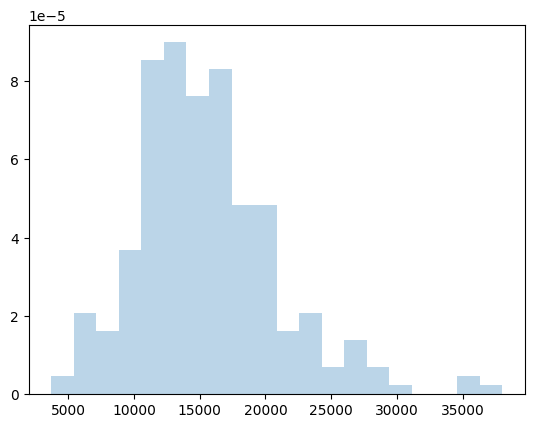

In [126]:
import matplotlib.pyplot as plt
plt.hist(counts,bins=20,alpha=0.3,density=True);

In [122]:
np.mean(counts), np.mean(counts2)

(15461.816, 14927.192)

## Norman 2019 Science dataset - makes sense

In [ ]:
from gears import PertData, GEARS
from gears.utils import dataverse_download
import tarfile

In [ ]:
## Download dataloader from dataverse
dataverse_download('https://dataverse.harvard.edu/api/access/datafile/6979957', 'norman_umi_go.tar.gz')

## Extract and set up dataloader directory

with tarfile.open('norman_umi_go.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [33]:
df = scp.read_h5ad('./data/Norman_2019/norman_umi_go/perturb_processed.h5ad')

In [37]:
perts = df.obs.condition.unique().tolist()

In [41]:
tfs = pd.read_csv('TF_db.csv', index_col=0)

In [48]:
TF_ids = tfs['HGNC symbol'].unique().tolist()

In [52]:
match = 0
for p in perts:
    temp = p.split('+')
    temp_match = 0
    for t in temp:
        if t in TF_ids:
            temp_match+=1
        if temp_match==2:
            match+=1
        

## In Normal there are 51 perturbation of two-TFs and 185 single-TF

In [53]:
match

51

In [212]:
df.var.loc[df.uns['top_non_dropout_de_20']['K562_FOXA3+ctrl_1+1']].values.squeeze()

array(['LYZ', 'GAL', 'FOXA3', 'GYPB', 'FTH1', 'PTMA', 'OAZ1', 'RANBP1',
       'MT-CO1', 'KRT8', 'ALAS2', 'TEX30', 'SEC61G', 'FABP5', 'RAN',
       'PRSS57', 'STAT5A', 'FKBP4', 'SMYD3', 'PSMB9'], dtype=object)

In [59]:
treat_cells = df.obs[df.obs.condition=='FOXA3+ctrl'].index

In [48]:
ctrl_cells = df.obs[df.obs.condition=='ctrl'].index

#### Apply normalization as suggested in the paper

In [231]:
scp.pp.normalize_total(df)
scp.pp.log1p(df)
scp.pp.highly_variable_genes(df,n_top_genes=5000, subset=True)

In [63]:
from tqdm import tqdm

In [261]:
treat = np.zeros(shape=(len(treat_cells),5000),dtype=np.float32)
counter=0
for cell in tqdm(treat_cells):
    a = df[cell].X.toarray()
    treat[counter, :] = a
    counter+=1
#treat_summa/=counter
treat_mean = np.mean(treat, axis=0)
treat_std = np.std(treat, axis=0)

100%|█████████████████████████████████████████████████████████████████| 409/409 [00:01<00:00, 318.82it/s]


In [262]:
ctrl = np.zeros(shape=(len(ctrl_cells),5000),dtype=np.float32)
counter=0
for cell in tqdm(ctrl_cells):
    a = df[cell].X.toarray()
    ctrl[counter, :] = a
    counter+=1
#treat_summa/=counter
ctrl_mean = np.mean(ctrl, axis=0)
ctrl_std = np.std(ctrl, axis=0)

100%|███████████████████████████████████████████████████████████████| 7353/7353 [00:20<00:00, 365.18it/s]


In [263]:
non_zero_DE = ['LYZ', 'GAL', 'FOXA3', 'GYPB', 'FTH1', 'PTMA', 'OAZ1', 'RANBP1',
               'MT-CO1', 'KRT8', 'ALAS2', 'TEX30', 'SEC61G', 'FABP5', 'RAN',
               'PRSS57', 'STAT5A', 'FKBP4', 'SMYD3', 'PSMB9']

In [264]:
import matplotlib.pyplot as plt

In [265]:
ctrl_mean_f = ctrl_mean#[(ctrl_mean!=0) & (treat_mean!=0)]
treat_mean_f = treat_mean#[(ctrl_mean!=0) & (treat_mean!=0)]

ctrl_std_f = ctrl_std#[(ctrl_mean!=0) & (treat_mean!=0)]
treat_std_f = treat_std#[(ctrl_mean!=0) & (treat_mean!=0)]

genes = df.var.gene_name.values #.loc[(ctrl_mean!=0) & (treat_mean!=0)]


In [266]:
genes

['RP11-34P13.8', 'FO538757.2', 'SAMD11', 'NOC2L', 'ISG15', ..., 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC023491.2', 'AC004556.1']
Length: 5000
Categories (5000, object): ['A2M', 'AAED1', 'AAK1', 'AAMDC', ..., 'ZPR1', 'ZRANB2', 'ZSCAN16-AS1', 'ZWINT']

In [267]:
of_interest = np.argsort(abs(ctrl_mean_f-treat_mean_f))[-20:]

In [268]:
genes[of_interest]

['MDK', 'NDUFAF2', 'DCTPP1', 'CFH', 'GYPE', ..., 'KRT8', 'GYPB', 'ALAS2', 'GAL', 'LYZ']
Length: 20
Categories (5000, object): ['A2M', 'AAED1', 'AAK1', 'AAMDC', ..., 'ZPR1', 'ZRANB2', 'ZSCAN16-AS1', 'ZWINT']

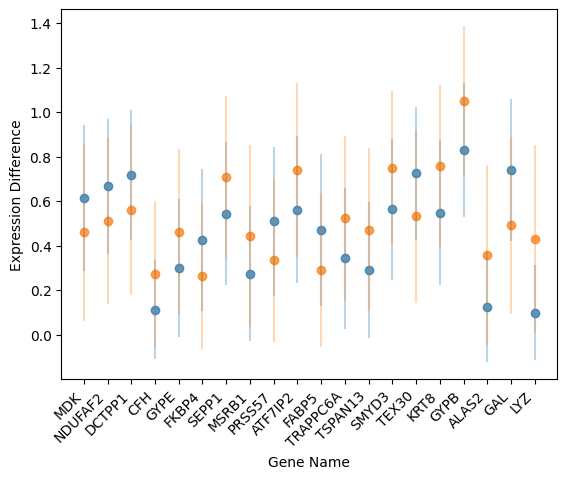

In [275]:
plt.scatter(x=genes[of_interest], y=ctrl_mean_f[of_interest],alpha=0.75,)
plt.scatter(x=genes[of_interest], y=treat_mean_f[of_interest],  alpha=0.75,)

plt.errorbar(x=genes[of_interest], y=ctrl_mean_f[of_interest], yerr=ctrl_std_f[of_interest], alpha=0.3,ls='none')
plt.errorbar(x=genes[of_interest], y=treat_mean_f[of_interest], yerr=treat_std_f[of_interest], alpha=0.3,ls='none')
plt.xlabel('Gene Name')
plt.ylabel('Expression Difference')
plt.xticks(rotation=45, ha='right');

In [276]:
disc_DE = genes[of_interest]

In [277]:
disc_DE

['MDK', 'NDUFAF2', 'DCTPP1', 'CFH', 'GYPE', ..., 'KRT8', 'GYPB', 'ALAS2', 'GAL', 'LYZ']
Length: 20
Categories (5000, object): ['A2M', 'AAED1', 'AAK1', 'AAMDC', ..., 'ZPR1', 'ZRANB2', 'ZSCAN16-AS1', 'ZWINT']

In [278]:
set(disc_DE).intersection(set(non_zero_DE))

{'ALAS2',
 'FABP5',
 'FKBP4',
 'GAL',
 'GYPB',
 'KRT8',
 'LYZ',
 'PRSS57',
 'SMYD3',
 'TEX30'}

In [279]:
non_zero_DE

['LYZ',
 'GAL',
 'FOXA3',
 'GYPB',
 'FTH1',
 'PTMA',
 'OAZ1',
 'RANBP1',
 'MT-CO1',
 'KRT8',
 'ALAS2',
 'TEX30',
 'SEC61G',
 'FABP5',
 'RAN',
 'PRSS57',
 'STAT5A',
 'FKBP4',
 'SMYD3',
 'PSMB9']